# Neural Network

In [1]:
import numpy as np

class NeuralNetwork:
    '''
    Defines a neural network for regression. Uses a single hidden layer, ReLU non-linearity, L2-regularization, and He initilization.
    '''
    def __init__(self, input_dim, hidden_dim, output_dim, epochs=1000, lr=0.1, lambda_=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.lr = lr
        self.lambda_ = lambda_
        self.w1 = np.random.randn(self.input_dim + 1, self.hidden_dim) * np.sqrt(2 / (self.input_dim + 1))
        self.w2 = np.random.randn(self.hidden_dim + 1, self.output_dim) * np.sqrt(2 / (self.hidden_dim + 1))
        self.train_error = list()
        self.val_error = list()
        
    def forward(self, X, save=True):
        a0 = self._pad_ones(X)
        z1 = np.dot(a0, self.w1)
        a1 = self._relu(z1)
        a1 = self._pad_ones(a1)
        z2 = np.dot(a1, self.w2)
        if save:
            self.a0, self.z1, self.a1, self.z2 = a0, z1, a1, z2
        return z2
        
    def train(self, X, y, val=None):
        y_ = self._transpose_dim(y)
        if val is not None:
            X_val, y_val = val
        for _ in range(self.epochs):
            y_hat = self.forward(X)
            self.train_error.append(np.mean(np.abs(y - y_hat)))
            if val is not None:
                self.val_error.append(np.mean(np.abs(y_val - self.forward(X_val, save=False))))
            delta2 = self._transpose_dim(self.z2) - y_
            delta1 = np.matmul(delta2, np.expand_dims(self.w2[:-1,:].T, axis=0)) * np.maximum(self._transpose_dim(self.z1), np.zeros((1, 1, 1)))
            dCdw1 = np.matmul(np.expand_dims(self.a0, axis=2), delta1) + self.lambda_ * self.w1
            dCdw2 = np.matmul(np.expand_dims(self.a1, axis=2), delta2) + self.lambda_ * self.w2
            self.w1 -= self.lr * np.mean(dCdw1, axis=0)
            self.w2 -= self.lr * np.mean(dCdw2, axis=0)
        
    def __call__(self, X):
        return self.forward(X)
        
    def _relu(self, X):
        return np.maximum(X, np.zeros((1, 1)))
    
    def _relu_grad(self, X):
        return (X > 0).astype(float)
    
    def _pad_ones(self, X):
        N = X.shape[0]
        return np.concatenate([X, np.ones((N, 1))], axis=1)
    
    def _transpose_dim(self, X):
        return np.swapaxes(np.expand_dims(X, axis=2), 1, 2)

## Boston Dataset

In [2]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle
X, y = load_boston(return_X_y=True)
X = normalize(X)
y = np.expand_dims(y, axis=1)
X, y = shuffle(X, y)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25)

In [3]:
input_dim = X.shape[1]
hidden_dim = 10
output_dim = y.shape[1]
epochs = 150
lr = 0.001
lambda_ = 10.0
nn = NeuralNetwork(input_dim, hidden_dim, output_dim, epochs, lr, lambda_)
nn.train(X_train, y_train, (X_val, y_val))
train_error, val_error = np.array(nn.train_error), np.array(nn.val_error)
y_val_pred = nn(X_val)
print("Validation")
print("MAE: {:f}, MSE: {:f}".format(mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred)))

Validation
MAE: 6.354618, MSE: 91.287506


## Plot Learning Curves

<IPython.core.display.Javascript object>


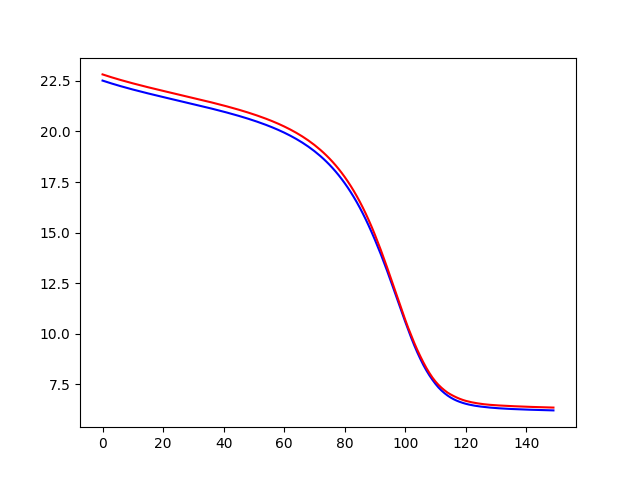

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
N = train_error.shape[0]
plt.plot(np.arange(N), train_error, 'b')
plt.plot(np.arange(N), val_error, 'r')
plt.show()

## Test Accuracy

In [5]:
y_pred = nn(X_test)
print("Test")
print("MAE: {:f}, MSE: {:f}".format(mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

Test
MAE: 6.219341, MSE: 83.438591
